[info] Using font: NanumGothic


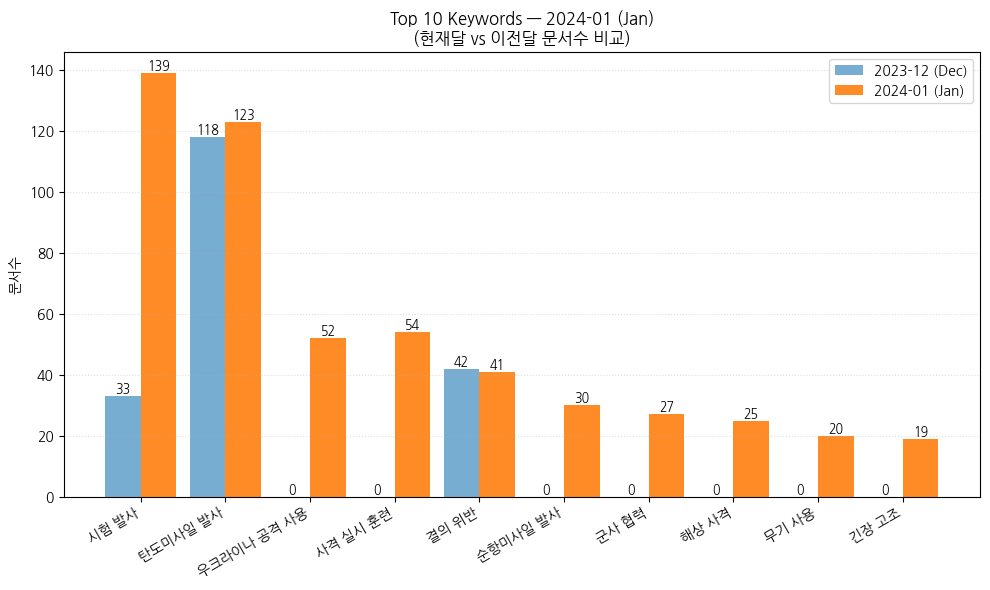

In [ ]:
# -*- coding: utf-8 -*-
import json
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patheffects as path_effects  # (라벨 윤곽선 쓰면 유용)
from matplotlib import font_manager
import glob
import calendar

# ====== 사용자 설정 ======
DATA_DIR = Path(r"/home/ds4_sia_nolb/#FINAL_POLARIS/07_Visualization/1.top_keyword/re_monthly_keyword_change_volume")
YEAR = 2024
MONTH = 1
TOP_N = 15
FILE_NAME = f"yearly_analysis_{YEAR}.json"


# ====== [필수] 폰트 직접 등록 & 강제 선택 ======
FONT_PATH_GLOBS = [
    "/usr/share/fonts/truetype/nanum/*.ttf",
    "/usr/share/fonts/opentype/noto/*KR*.*",
    "/usr/share/fonts/opentype/noto/*CJK*.*",
    "/usr/share/fonts/*/*Noto*KR*.*",
    "/usr/share/fonts/*/*Nanum*.*",
    "~/.local/share/fonts/*Nanum*.*",
    "~/.local/share/fonts/*Noto*KR*.*",
]
font_files = []
for pattern in FONT_PATH_GLOBS:
    font_files.extend(glob.glob(pattern))
    font_files.extend(glob.glob(pattern.replace("~", str(Path.home()))))

for fp in font_files:
    try:
        font_manager.fontManager.addfont(fp)
    except Exception:
        pass

available_fonts = {f.name for f in font_manager.fontManager.ttflist}
FONT_CANDIDATES = ["NanumGothic", "Noto Sans CJK KR", "Noto Sans KR", "NanumBarunGothic", "AppleGothic", "DejaVu Sans"]
picked = next((n for n in FONT_CANDIDATES if n in available_fonts), None)

if picked:
    mpl.rcParams["font.family"] = picked
    print(f"[info] Using font: {picked}")
else:
    # family 매칭을 위해 sans-serif 후보도 함께 넣어둠(최후의 보루: DejaVu)
    mpl.rcParams["font.sans-serif"] = FONT_CANDIDATES
    print("[경고] 한글 폰트를 family 이름으로 찾지 못했습니다. 그래도 한글이 깨지면 fc-list로 경로 확인 후 addfont에 직접 경로 넣어주세요.")

mpl.rcParams["axes.unicode_minus"] = False



def month_label(year: int, month: int):
    """예: (2024, 6) -> '2024-06 (Jun)'"""
    return f"{year}-{month:02d} ({calendar.month_abbr[month]})"

def get_prev_year_month(year: int, month: int):
    """현재 월의 이전달 (연도 넘어갈 수 있음)"""
    if month == 1:
        return year - 1, 12
    return year, month - 1

def load_year_json(path: Path) -> dict:
    with open(path, "r", encoding="utf-8") as f:
        return json.load(f)

def build_current_month_df(js: dict, month: int) -> pd.DataFrame:
    """해당 YEAR의 MONTH에서, 전월 매칭이 반영된 changes를 DataFrame으로 변환"""
    mm_key = f"{month:02d}"
    monthly = (js or {}).get("monthly_changes", {})
    if mm_key not in monthly:
        return pd.DataFrame()

    changes = monthly[mm_key].get("changes", [])
    cols = [
        "rank", "current_phrase",
        "current_doc_count", "previous_doc_count",
        "current_score", "previous_score",
        "matched_phrase", "status"
    ]
    df = pd.DataFrame(changes)
    for c in ["current_doc_count", "previous_doc_count", "current_score", "previous_score"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce").fillna(0)

    # 현재달 랭킹 기준 정렬 → TOP_N
    if "rank" in df.columns and df["rank"].notna().any():
        df = df.sort_values(["rank"]).head(TOP_N).reset_index(drop=True)
    else:
        df = df.sort_values(["current_doc_count"], ascending=False).head(TOP_N).reset_index(drop=True)

    # 필요한 컬럼만 남기기(없으면 자동 드롭)
    df = df[[c for c in cols if c in df.columns]]
    return df

# 1) 데이터 로드
js = load_year_json(DATA_DIR / FILE_NAME)
df = build_current_month_df(js, MONTH)

if df.empty:
    print(f"데이터가 없습니다: YEAR={YEAR}, MONTH={MONTH}")
else:
    # 2) 라벨 만들기
    prev_y, prev_m = get_prev_year_month(YEAR, MONTH)
    label_prev = month_label(prev_y, prev_m)
    label_curr = month_label(YEAR, MONTH)

    phrases = df["current_phrase"].astype(str)
    prev_vals = df["previous_doc_count"].fillna(0).astype(int)
    curr_vals = df["current_doc_count"].fillna(0).astype(int)

    x = np.arange(len(df))
    width = 0.42

    # 3) 그래프 그리기 (한 개 플롯에 이전달/이번달 나란히)
    fig, ax = plt.subplots(figsize=(max(10, len(df) * 0.55), 6))
    ax.bar(x - width/2, prev_vals, width, label=label_prev, alpha=0.6)
    ax.bar(x + width/2, curr_vals, width, label=label_curr, alpha=0.9)

    ax.set_title(f"Top {len(df)} Keywords — {label_curr}\n(현재달 vs 이전달 문서수 비교)")
    ax.set_ylabel("문서수")
    ax.set_xticks(x)
    ax.set_xticklabels(phrases, rotation=30, ha="right")

    # 값 라벨 (막대 위 숫자)
    for i, v in enumerate(prev_vals):
        ax.text(i - width/2, v, f"{v}", ha="center", va="bottom", fontsize=9)
    for i, v in enumerate(curr_vals):
        ax.text(i + width/2, v, f"{v}", ha="center", va="bottom", fontsize=9)

    ax.legend()
    ax.grid(axis="y", linestyle=":", alpha=0.4)
    plt.tight_layout()
    plt.show()

    # (옵션) 변화폭 그래프도 보고 싶으면 주석 해제
    # fig2, ax2 = plt.subplots(figsize=(max(10, len(df) * 0.55), 4.5))
    # delta = curr_vals - prev_vals
    # ax2.bar(x, delta)
    # ax2.set_title(f"증감폭 (이번달 - 이전달) — {label_curr}")
    # ax2.set_ylabel("증감 문서수")
    # ax2.set_xticks(x)
    # ax2.set_xticklabels(phrases, rotation=30, ha="right")
    # for i, v in enumerate(delta):
    #     ax2.text(i, v, f"{int(v)}", ha="center", va="bottom", fontsize=9)
    # plt.tight_layout()
    # plt.show()
